# Marche Immobilier

In [1]:
# ============================================================================
# IMPORTS
# ============================================================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from IPython.display import display, clear_output

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)

## Chargement des données

In [2]:
# ============================================================================
# IMPORT DES DONNÉES
# ============================================================================
df = pd.read_csv('donnees/statistiques_grandes_villes_2020_2024_toutes_colonnes.csv', sep=';')
df_etu = pd.read_csv("donnees/fr-esr-atlas_regional-effectifs-d-etudiants-inscrits.csv", sep=';', encoding='utf-8')
df_inciv = pd.read_csv("donnees/incivilites_filtrees.csv", sep=';', encoding='utf-8')
df_dept = pd.read_csv("donnees/population_departement_filtree.csv", sep=';', encoding='utf-8')

In [3]:
df.columns = df.columns.str.strip()

def corriger_annee(row):
    annee = row['annee']
    ville = row['ville']
    if pd.isna(annee):
        return None
    annee = int(annee)
    if ville == 'Lyon' and 20200 <= annee <= 20240:
        return 2020 + (annee - 20200) // 10
    if ville == 'Marseille' and 38380 <= annee <= 38460:
        return {38380: 2020, 38399: 2021, 38418: 2022, 38437: 2023, 38456: 2024}.get(annee)
    if ville == 'Paris' and 46460 <= annee <= 46560:
        return {46460: 2020, 46483: 2021, 46506: 2022, 46529: 2023, 46552: 2024}.get(annee)
    if 2020 <= annee <= 2024:
        return annee
    return None

df['annee_corrigee'] = df.apply(corriger_annee, axis=1)
df = df.dropna(subset=['annee_corrigee'])
df['annee'] = df['annee_corrigee'].astype(int)

df['prix_m2_moyen'] = pd.to_numeric(df['prix_m2_moyen'], errors='coerce')
df['nb_transactions'] = pd.to_numeric(df['nb_transactions'], errors='coerce')
df = df.dropna(subset=['prix_m2_moyen', 'ville'])

villes = sorted(df['ville'].unique())
print(f"✅ Données prêtes ({len(df)} lignes). Villes disponibles : {', '.join(villes)}")


✅ Données prêtes (45 lignes). Villes disponibles : Bordeaux, Grenoble, Lille, Lyon, Marseille, Montpellier, Paris, Rennes, Toulouse


## Widget n°1 (Interactif): Choix des villes étudiantes

In [4]:


# On part du principe que 'df' existe déjà (chargé dans la cellule import/traitement).
# Créez ici les checkboxes — variable globale city_checkboxes utilisée ensuite.
city_checkboxes = [widgets.Checkbox(value=False, description=v) for v in sorted(df['ville'].unique())]

# Contrôles pratiques : Sélectionner tout / Décocher tout
btn_select_all = widgets.Button(description="Tout cocher", button_style='info')
btn_clear_all  = widgets.Button(description="Tout décocher", button_style='warning')

def select_all(b):
    for cb in city_checkboxes:
        cb.value = True

def clear_all(b):
    for cb in city_checkboxes:
        cb.value = False

btn_select_all.on_click(select_all)
btn_clear_all.on_click(clear_all)

# Affichage : titre + boutons + grille de checkboxes
grid = widgets.GridBox(city_checkboxes, layout=widgets.Layout(grid_template_columns="repeat(3, 220px)"))
ui_select = widgets.VBox([
    widgets.HBox([btn_select_all, btn_clear_all]),
    grid,
])

display(ui_select)


## Widget n°2 (Affichage) : Evolution marché immobilier des villes du widget n°1

In [5]:


# ============================================================================
# INTERFACE WIDGETS
# ============================================================================
output_evolution_prix_m2 = widgets.Output()
output_evolution_taux = widgets.Output()
output_evolution_transactions = widgets.Output()

display(output_evolution_prix_m2, output_evolution_taux, output_evolution_transactions)

# ============================================================================
# FONCTIONS DE VISUALISATION
# ============================================================================

def creer_graphique_evolution_prix(df, villes_selectionnees):
    """📈 Évolution du prix moyen au m² (2020–2024)"""
    df_plot = df[df['ville'].isin(villes_selectionnees)].sort_values(['ville', 'annee'])

    fig = px.line(
        df_plot,
        x='annee',
        y='prix_m2_moyen',
        color='ville',
        markers=True,
        title="📈 Évolution du prix moyen au m² (2020–2024)",
        labels={'annee': 'Année', 'prix_m2_moyen': 'Prix moyen au m² (€)', 'ville': 'Ville'}
    )

    fig.update_layout(
        hovermode='x unified',
        height=400,
        legend_title_text="Villes",
        margin=dict(l=60, r=40, t=60, b=60)
    )

    return fig


def creer_graphique_evolution_taux(df, villes_selectionnees):
    """📊 Taux d’évolution du prix moyen au m² (2020 → 2024)"""
    evol_prix = []
    for ville in villes_selectionnees:
        data = df[df['ville'] == ville]
        p2020 = data[data['annee'] == 2020]['prix_m2_moyen']
        p2024 = data[data['annee'] == 2024]['prix_m2_moyen']
        if len(p2020) and len(p2024) and p2020.iloc[0] != 0:
            taux = ((p2024.iloc[0] - p2020.iloc[0]) / p2020.iloc[0]) * 100
            evol_prix.append((ville, taux))

    if not evol_prix:
        print("⚠️ Pas de données suffisantes pour calculer l’évolution du prix.")
        return go.Figure()

    villes_graph, taux_graph = zip(*evol_prix)
    df_plot = pd.DataFrame({'Ville': villes_graph, 'Taux (%)': taux_graph})

    fig = px.bar(
        df_plot,
        x='Taux (%)',
        y='Ville',
        orientation='h',
        color='Taux (%)',
        color_continuous_scale=['#D32F2F', '#388E3C'],
        title="📊 Taux d’évolution du prix moyen au m² (2020–2024)",
    )

    fig.update_layout(height=400, coloraxis_showscale=False)
    return fig


def creer_graphique_transactions(df, villes_selectionnees):
    """🏠 Évolution du nombre de transactions (2020 → 2024)"""
    evol_trans = []
    for ville in villes_selectionnees:
        data = df[df['ville'] == ville]
        t2020 = data[data['annee'] == 2020]['nb_transactions']
        t2024 = data[data['annee'] == 2024]['nb_transactions']
        if len(t2020) and len(t2024) and t2020.iloc[0] != 0:
            taux = ((t2024.iloc[0] - t2020.iloc[0]) / t2020.iloc[0]) * 100
            evol_trans.append((ville, taux))

    if not evol_trans:
        print("⚠️ Pas de données suffisantes pour afficher les transactions.")
        return go.Figure()

    villes_graph, taux_graph = zip(*evol_trans)
    df_plot = pd.DataFrame({'Ville': villes_graph, 'Taux (%)': taux_graph})

    fig = px.bar(
        df_plot,
        x='Taux (%)',
        y='Ville',
        orientation='h',
        color='Taux (%)',
        color_continuous_scale=['#D32F2F', '#388E3C'],
        title="🏠 Taux d’évolution du nombre de transactions (2020–2024)",
    )

    fig.update_layout(height=400, coloraxis_showscale=False)
    return fig

# ============================================================================
# MISE À JOUR AUTOMATIQUE
# ============================================================================

def update_graphiques(change=None):
    villes_selectionnees = [cb.description for cb in city_checkboxes if cb.value]
    if not villes_selectionnees:
        print("⚠ Veuillez sélectionner au moins une ville.")
        return

    # Vider les sorties précédentes
    output_evolution_prix_m2.clear_output()
    output_evolution_taux.clear_output()
    output_evolution_transactions.clear_output()

    # Affichage des graphiques
    with output_evolution_prix_m2:
        creer_graphique_evolution_prix(df, villes_selectionnees).show()

    with output_evolution_taux:
        creer_graphique_evolution_taux(df, villes_selectionnees).show()

    with output_evolution_transactions:
        creer_graphique_transactions(df, villes_selectionnees).show()


# 🔗 Lier les cases à cocher à la mise à jour
for cb in city_checkboxes:
    cb.observe(update_graphiques, names='value')

update_graphiques()


Output()

Output()

Output()

## Widget : Etudiants

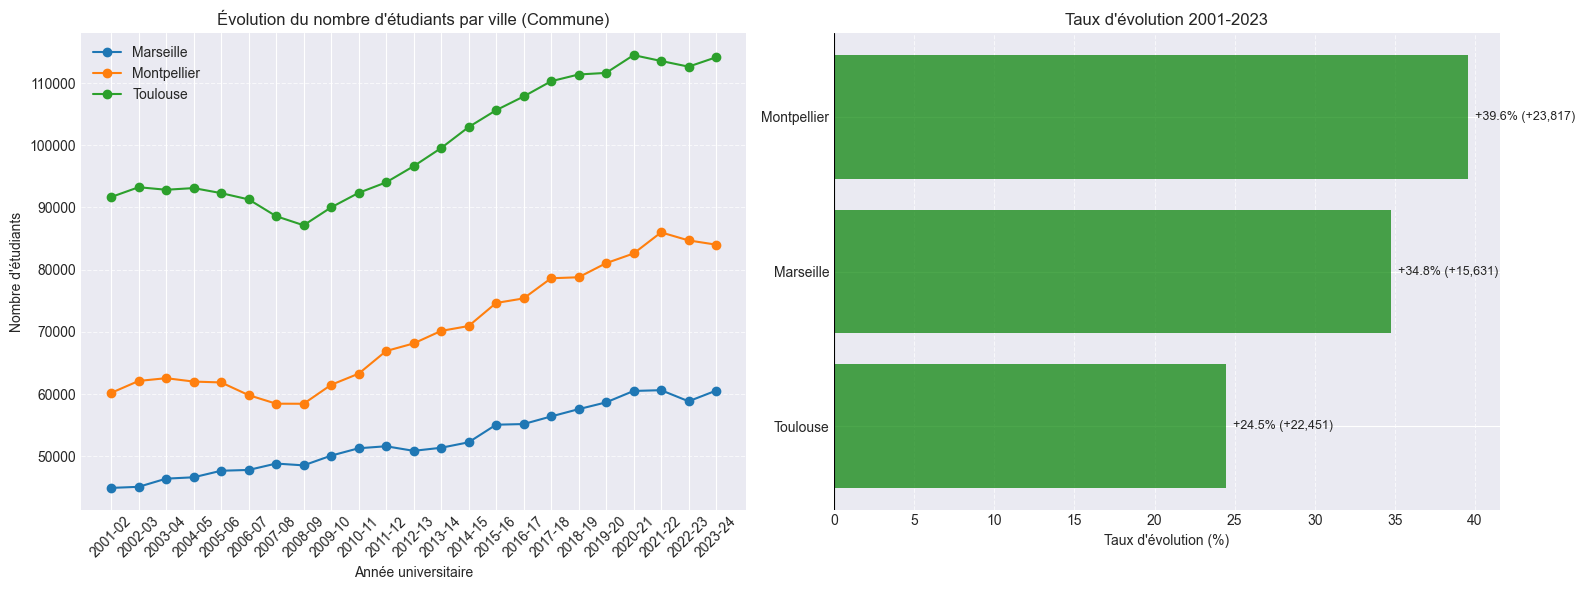

In [6]:
# Liste des villes à analyser
villes_a_analyser = [cb.description for cb in city_checkboxes if cb.value]

# Filtrer uniquement les lignes où le niveau géographique est "Commune"
df_communes = df_etu[df_etu['niveau_geographique'] == "Commune"].copy()
df_Final = df_communes[df_communes['regroupement'] == "TOTAL"].copy()

# ===============================
# 🔧 Gestion des villes à arrondissements
# ===============================
df_Final['ville_principale'] = df_Final['geo_nom']

# Regrouper tous les arrondissements sous le même nom
df_Final.loc[df_Final['geo_nom'].str.contains("Paris", case=False, na=False), 'ville_principale'] = "Paris"
df_Final.loc[df_Final['geo_nom'].str.contains("Lyon", case=False, na=False), 'ville_principale'] = "Lyon"
df_Final.loc[df_Final['geo_nom'].str.contains("Marseille", case=False, na=False), 'ville_principale'] = "Marseille"

# ===============================
# 🔍 Filtrer les villes choisies
# ===============================
df_villes = df_Final[df_Final['ville_principale'].isin(villes_a_analyser)].copy()

# ===============================
# 📊 Regrouper par ville et année
# ===============================
effectifs_par_ville_annee = (
    df_villes.groupby(['ville_principale', 'annee_universitaire'])['effectif']
    .sum()
    .reset_index()
)

# ===============================
# 📈 Calculer le delta et le taux d'évolution (2001-2023)
# ===============================
stats_evolution = []

for ville in effectifs_par_ville_annee['ville_principale'].unique():
    data_ville = effectifs_par_ville_annee[effectifs_par_ville_annee['ville_principale'] == ville]

    # Rechercher les données pour 2001 et 2023
    effectif_2001 = data_ville[data_ville['annee_universitaire'] == '2001-02']['effectif']
    effectif_2023 = data_ville[data_ville['annee_universitaire'] == '2023-24']['effectif']

    if not effectif_2001.empty and not effectif_2023.empty:
        val_2001 = effectif_2001.values[0]
        val_2023 = effectif_2023.values[0]
        delta = val_2023 - val_2001
        taux_evolution = ((val_2023 - val_2001) / val_2001) * 100

        stats_evolution.append({
            'Ville': ville,
            'Effectif 2001': val_2001,
            'Effectif 2023': val_2023,
            'Delta': delta,
            'Taux d\'évolution (%)': round(taux_evolution, 2)
        })

# ===============================
# 🎨 AFFICHAGE
# ===============================
if effectifs_par_ville_annee.empty:
    print("⚠️ Aucune donnée à afficher pour les villes sélectionnées.")
else:
    # Créer une figure avec 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # ===== GRAPHIQUE 1 : Évolution temporelle =====
    villes = effectifs_par_ville_annee['ville_principale'].unique()

    for ville in villes:
        data_ville = effectifs_par_ville_annee[effectifs_par_ville_annee['ville_principale'] == ville]
        ax1.plot(data_ville['annee_universitaire'], data_ville['effectif'], marker='o', label=ville)

    ax1.set_title("Évolution du nombre d'étudiants par ville (Commune)")
    ax1.set_xlabel("Année universitaire")
    ax1.set_ylabel("Nombre d'étudiants")
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend()
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # ===== GRAPHIQUE 2 : Taux d'évolution =====
    if stats_evolution:
        df_stats = pd.DataFrame(stats_evolution)

        # 🔥 TRI PAR TAUX D'ÉVOLUTION DÉCROISSANT
        df_stats = df_stats.sort_values('Taux d\'évolution (%)', ascending=True)  # ascending=True pour que le plus élevé soit en haut

        colors = ['green' if x > 0 else 'red' for x in df_stats['Taux d\'évolution (%)']]
        bars = ax2.barh(df_stats['Ville'], df_stats['Taux d\'évolution (%)'], color=colors, alpha=0.7)

        # Ajouter les valeurs sur les barres
        for i, (taux, delta) in enumerate(zip(df_stats['Taux d\'évolution (%)'], df_stats['Delta'])):
            ax2.text(taux, i, f'  {taux:+.1f}% ({delta:+,.0f})',
                    va='center', ha='left' if taux > 0 else 'right', fontsize=9)

        ax2.set_title("Taux d'évolution 2001-2023")
        ax2.set_xlabel("Taux d'évolution (%)")
        ax2.axvline(0, color='black', linewidth=0.8, linestyle='-')
        ax2.grid(axis='x', linestyle='--', alpha=0.7)
    else:
        ax2.text(0.5, 0.5, "Données 2001 ou 2023\nnon disponibles",
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
        ax2.set_title("Taux d'évolution 2001-2023")

    plt.tight_layout()
    plt.show()

## Widget n°3 (bis) : Evolution des incivilités en France

In [7]:

# ============================================================================
# CONFIGURATION
# ============================================================================



VILLES_DEPARTEMENTS = {
    'Rennes': '35',
    'Toulouse': '31',
    'Lyon': '69',
    'Bordeaux': '33',
    'Lille': '59',
    'Montpellier': '34',
    'Paris': '75',
    'Marseille': '13',
    'Grenoble': '38'
}

# ============================================================================
# CHARGEMENT DES DONNÉES
# ============================================================================

# Garde uniquement les 2 ou 3 premiers caractères pour correspondre au code dans VILLES_DEPARTEMENTS
df_inciv['Zone_code'] = df_inciv['Zone_geographique'].astype(str).str[:2]  # pour '35-Ille-et-Vilaine' → '35'
df_inciv['ville'] = df_inciv['Zone_code'].map({v: k for k, v in VILLES_DEPARTEMENTS.items()})


# Ajouter une colonne nombre_incivilites si elle n'existe pas
if 'Valeurs' not in df_inciv.columns:
    df_inciv['Valeurs'] = 1

# Ajouter la colonne 'categorie' si elle n'existe pas
if 'Indicateur' not in df_inciv.columns:
    df_inciv['Indicateur'] = 'Total'

if 'Unite_temps' not in df_inciv.columns:
    raise ValueError("La colonne 'Unite_temps' doit exister et contenir l'année.")
# ============================================================================
# AGRÉGATION
# ============================================================================

df_agg = df_inciv.groupby(['ville', 'Unite_temps', 'Indicateur'])['Valeurs'].sum().reset_index()

# ============================================================================
# INTERFACE INTERACTIVE
# ============================================================================

# Output pour les graphiques
output_evolution = widgets.Output()
output_categories = widgets.Output()
output_heatmap = widgets.Output()
output_heatmap_par_pop = widgets.Output()
display(output_evolution, output_categories, output_heatmap, output_heatmap_par_pop)


def creer_graphique_evolution(df_inciv, villes_selectionnees):
    df_plot = df_inciv[df_inciv['ville'].isin(villes_selectionnees)].groupby(['ville', 'Unite_temps'])['Valeurs'].sum().reset_index()
    fig = px.line(df_plot, x='Unite_temps', y='Valeurs', color='ville', markers=True,
                  title="Évolution du nombre d'incivilités par ville",
                  labels={'Unite_temps':'Année', 'Valeurs':'Nombre d\'incivilités'})
    fig.update_layout(hovermode='x unified', height=400)

    return fig

def creer_graphique_categories(df_inciv, villes_selectionnees):
    df_plot = df_inciv[df_inciv['ville'].isin(villes_selectionnees)].groupby(['ville','Indicateur'])['Valeurs'].sum().reset_index()
    fig = px.bar(df_plot, x='ville', y='Valeurs', color='Indicateur', barmode='group',
                 title="Répartition des incivilités par catégorie et par ville",
                 labels={'ville':'Ville', 'Valeurs':'Nombre d\'incivilités','Indicateur':'Catégorie'})
    fig.update_layout(height=400, xaxis_tickangle=-45)
    return fig

def creer_heatmap(df_inciv, villes_selectionnees):
    df_plot = df_inciv[df_inciv['ville'].isin(villes_selectionnees)].groupby(['ville','Unite_temps'])['Valeurs'].sum().reset_index()
    df_pivot = df_plot.pivot(index='ville', columns='Unite_temps', values='Valeurs')
    fig = go.Figure(data=go.Heatmap(
        z=df_pivot.values,
        x=df_pivot.columns,
        y=df_pivot.index,
        colorscale='Reds',
        text=df_pivot.values,
        texttemplate='%{text:.0f}',
        colorbar=dict(title="Nombre d'incivilités")
    ))
    fig.update_layout(title="Intensité des incivilités par ville et année", xaxis_title="Année", yaxis_title="Ville", height=400)
    return fig

def creer_heatmap_par_pop(df_inciv, villes_selectionnees):
    """
    Crée une heatmap du taux d'incivilités pour 1000 habitants.
    """
    df_local = df_inciv.copy()
    df_local['Zone_code'] = df_local['Zone_geographique'].astype(str).str[:2]
    df_local['ville'] = df_local['Zone_code'].map({v: k for k, v in VILLES_DEPARTEMENTS.items()})
    df_local = df_local.dropna(subset=['ville'])
    df_local = df_local[df_local['ville'].isin(villes_selectionnees)]

    if df_local.empty:
        print("⚠️ Aucune donnée trouvée pour les villes sélectionnées.")
        return go.Figure()

    code_to_nom_dep = {
        '35': 'Ille-et-Vilaine',
        '31': 'Haute-Garonne',
        '69': 'Rhône',
        '33': 'Gironde',
        '59': 'Nord',
        '34': 'Hérault',
        '75': 'Paris',
        '13': 'Bouches-du-Rhône',
        '38': 'Isère'
    }
    df_local['nom_dep'] = df_local['Zone_code'].map(code_to_nom_dep)
    df_local['Unite_temps'] = df_local['Unite_temps'].astype(int)
    df_dept['annee'] = df_dept['annee'].astype(int)

    df_merged = pd.merge(
        df_local,
        df_dept,
        left_on=['nom_dep', 'Unite_temps'],
        right_on=['nom_dep', 'annee'],
        how='left'
    )

    df_merged['Valeurs'] = pd.to_numeric(df_merged['Valeurs'], errors='coerce')
    df_merged['population_municipale'] = pd.to_numeric(df_merged['population_municipale'], errors='coerce')
    df_merged['taux_incivilites'] = (df_merged['Valeurs'] / df_merged['population_municipale']) * 1000

    df_plot = df_merged.dropna(subset=['taux_incivilites']).groupby(['ville', 'Unite_temps'])['taux_incivilites'].mean().reset_index()

    if df_plot.empty:
        print("⚠️ Aucune correspondance trouvée entre incivilités et population.")
        return go.Figure()

    df_pivot = df_plot.pivot(index='ville', columns='Unite_temps', values='taux_incivilites')

    fig = go.Figure(data=go.Heatmap(
        z=df_pivot.values,
        x=df_pivot.columns,
        y=df_pivot.index,
        colorscale='Reds',
        text=df_pivot.round(2).values,
        texttemplate='%{text}',
        colorbar=dict(title="Incivilités / 1 000 habitants")
    ))

    fig.update_layout(
        title="📊 Taux d’incivilités par ville et année (pour 1 000 habitants)",
        xaxis_title="Année",
        yaxis_title="Ville",
        height=450
    )

    return fig


def update_graphiques(change=None):
    # Récupère les villes sélectionnées dans la cellule 1
    villes_selectionnees = [cb.description for cb in city_checkboxes if cb.value]
    if not villes_selectionnees:
        print("⚠ Veuillez sélectionner au moins une ville.")
        return

    output_evolution.clear_output()
    output_categories.clear_output()
    output_heatmap.clear_output()
    output_heatmap_par_pop.clear_output()


    with output_evolution:
        creer_graphique_evolution(df_agg, villes_selectionnees).show()

    with output_categories:
        creer_graphique_categories(df_agg, villes_selectionnees).show()

    with output_heatmap:
        creer_heatmap(df_agg, villes_selectionnees).show()

    with output_heatmap_par_pop:
        creer_heatmap_par_pop(df_inciv, villes_selectionnees).show()

# Lier la mise à jour automatique aux checkboxes existantes
for cb in city_checkboxes:
    cb.observe(update_graphiques, names='value')

# Premier affichage
update_graphiques()



Output()

Output()

Output()

Output()

#### TEST